In [1]:
import glob
import os
import sys

sys.path.insert(0, "..")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector
vector.register_awkward()

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# define the global base device
world_size = torch.cuda.device_count()
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device 0: NVIDIA A10


# Top tagging dataset
Under `processed/` you should find three directories
- train
- valid
- test (which includes particle actual px,py,pz,e information for constructing subjets)

In [3]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw/data/*")

    data = []
    for i, file in enumerate(data_files):
        data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/data/data_{i}.npy"))
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data


def load_labels(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw/labels/*")

    data = []
    for i, file in enumerate(data_files):
        data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/labels/labels_{i}.npy")) 
        print(f"--- loaded label file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data

In [4]:
# prepare data
data_train = load_data(f"/ssl-jet-vol-v2/toptagging", "test", n_files=1)
labels_train = load_labels(f"/ssl-jet-vol-v2/toptagging", "test", n_files=1)

--- loaded file 0 from `test` directory
--- loaded label file 0 from `test` directory


In [5]:
all_jets = np.concatenate(data_train, axis=0)
all_labels = np.concatenate(labels_train, axis=0)

In [6]:
all_jets.shape  # pT, eta, phi

(100001, 7, 50)

In [7]:
all_labels.shape

(100001,)

In [8]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [9]:
num_features = 7

In [10]:
save_path = "../../toptagging/plots/7_raw"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

# Augmented Jets

In [18]:
!pwd

/ssl-jet-vol-v2/JetCLR/notebooks


In [11]:
from scripts.modules.jet_augs import *

In [20]:
def augmentation(x_i, device):
    """
    Applies all the augmentations specified in the args
    """
    # x_i has shape (batch_size, 7, n_constit)
    # dim 1 ordering: 'part_deta','part_dphi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
    # extract the (pT, eta, phi) features for augmentations
    pT = np.exp(x_i[:, 2, :])
    eta = x_i[:, 0, :]
    phi = x_i[:, 1, :]
    x_i = np.stack([pT, eta, phi], 1)  # (batch_size, 3, n_constit)
    time1 = time.time()
    #             print(x_i.shape)
    x_i = rotate_jets(x_i)
    x_j = x_i.copy()
    x_j = rotate_jets(x_j)
    time2 = time.time()
    x_j = collinear_fill_jets(x_j)
    x_j = collinear_fill_jets(x_j)
    time3 = time.time()
    x_j = distort_jets(x_j, strength=0.1, pT_clip_min=0.1)
    time4 = time.time()
    x_j = translate_jets(x_j, width=1.0)
    x_i = translate_jets(x_i, width=1.0)
    time5 = time.time()
    x_i = rescale_pts(x_i)
    x_j = rescale_pts(x_j)
    # recalculate the rest of the features after augmentation
    pT_i = x_i[:, 2, :]
    eta_i = x_i[:, 0, :]
    phi_i = x_i[:, 1, :]
    pT_j = x_j[:, 2, :]
    eta_j = x_j[:, 0, :]
    phi_j = x_j[:, 1, :]
    # calculate the rest of the features
    # pT
    pT_log_i = np.log(np.abs(pT_i))
    pT_log_i = np.nan_to_num(pT_log_i, nan=0.0)
    pT_log_j = np.log(np.abs(pT_j))
    pT_log_j = np.nan_to_num(pT_log_j, nan=0.0)
    # pTrel
    pT_sum_i = np.sum(pT_i, axis=-1, keepdims=True)
    pT_sum_j = np.sum(pT_j, axis=-1, keepdims=True)
    pt_rel_i = pT_i / pT_sum_i
    pt_rel_j = pT_j / pT_sum_j
    pt_rel_log_i = np.log(np.abs(pt_rel_i))
    pt_rel_log_i = np.nan_to_num(pt_rel_log_i, nan=0.0)
    pt_rel_log_j = np.log(np.abs(pt_rel_j))
    pt_rel_log_j = np.nan_to_num(pt_rel_log_j, nan=0.0)
    # E
    E_i = pT_i * np.cosh(eta_i)
    E_j = pT_j * np.cosh(eta_j)
    E_log_i = np.log(np.abs(E_i))
    E_log_i = np.nan_to_num(E_log_i, nan=0.0)
    E_log_j = np.log(np.abs(E_j))
    E_log_j = np.nan_to_num(E_log_j, nan=0.0)
    # Erel
    E_sum_i = np.sum(E_i, axis=-1, keepdims=True)
    E_sum_j = np.sum(E_j, axis=-1, keepdims=True)
    E_rel_i = E_i / E_sum_i
    E_rel_j = E_j / E_sum_j
    E_rel_log_i = np.log(np.abs(E_rel_i))
    E_rel_log_i = np.nan_to_num(E_rel_log_i, nan=0.0)
    E_rel_log_j = np.log(np.abs(E_rel_j))
    E_rel_log_j = np.nan_to_num(E_rel_log_j, nan=0.0)
    # deltaR
    deltaR_i = np.sqrt(np.square(eta_i) + np.square(phi_i))
    deltaR_j = np.sqrt(np.square(eta_j) + np.square(phi_j))
    # stack them to obtain the final augmented data
    x_i = np.stack(
        [
            eta_i,
            phi_i,
            pT_log_i,
            E_log_i,
            pt_rel_log_i,
            E_rel_log_i,
            deltaR_i,
        ],
        1,
    )  # (batch_size, 7, n_constit)
    x_j = np.stack(
        [
            eta_j,
            phi_j,
            pT_log_j,
            E_log_j,
            pt_rel_log_j,
            E_rel_log_j,
            deltaR_j,
        ],
        1,
    )  # (batch_size, 7, n_constit)
    x_i = torch.Tensor(x_i).transpose(1, 2).to(device)
    x_j = torch.Tensor(x_j).transpose(1, 2).to(device)
    return x_i

In [21]:
augmented_jets = augmentation(all_jets, "cpu")

In [22]:
augmented_jets.shape

torch.Size([100001, 50, 7])

# Data exploration

In [24]:
all_jets = torch.Tensor(all_jets)
all_labels = torch.Tensor(all_labels)

In [30]:
# check particle multiplicity for top quark jets vs qcd jets
multiplicity = {}
multiplicity["top"] = []
multiplicity["qcd"] = []

for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    multiplicity[label].append(int(torch.count_nonzero(jet) / 7))     

0it [00:00, ?it/s]

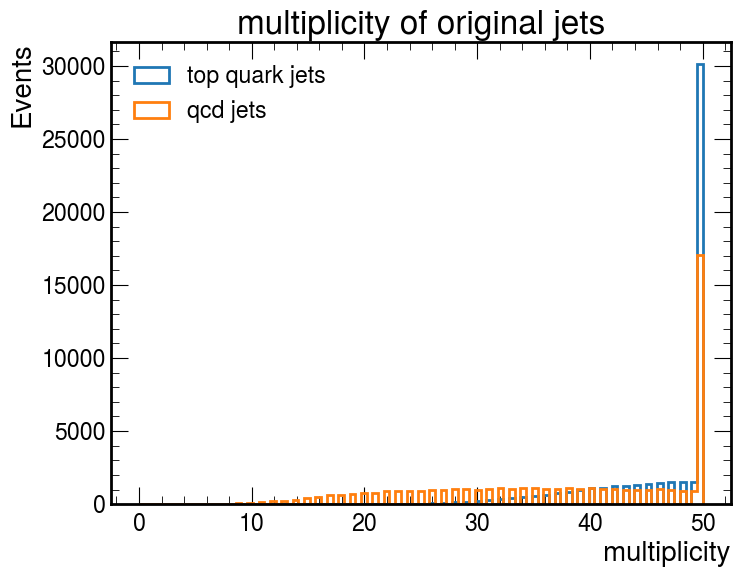

In [31]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(multiplicity["top"], bins=np.linspace(0,50,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(multiplicity["qcd"], bins=np.linspace(0,50,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(r"multiplicity");
ax.set_ylabel(r"Events"); 
plt.title("multiplicity of original jets")
plt.savefig(f"{save_path}/multiplicity_original", bbox_inches='tight', dpi=300)
plt.show()

In [32]:
# check particle multiplicity for top quark jets vs qcd jets
multiplicity = {}
multiplicity["top"] = []
multiplicity["qcd"] = []

for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    multiplicity[label].append(int(np.count_nonzero(jet) / 7))     

0it [00:00, ?it/s]

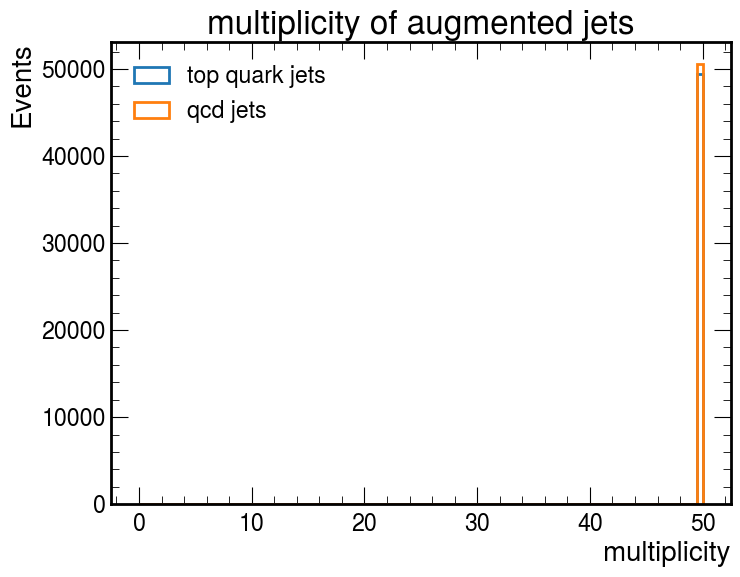

In [33]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(multiplicity["top"], bins=np.linspace(0,50,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(multiplicity["qcd"], bins=np.linspace(0,50,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(r"multiplicity");
ax.set_ylabel(r"Events"); 
plt.title("multiplicity of augmented jets")
plt.savefig(f"{save_path}/multiplicity_augmented", bbox_inches='tight', dpi=300)
plt.show()

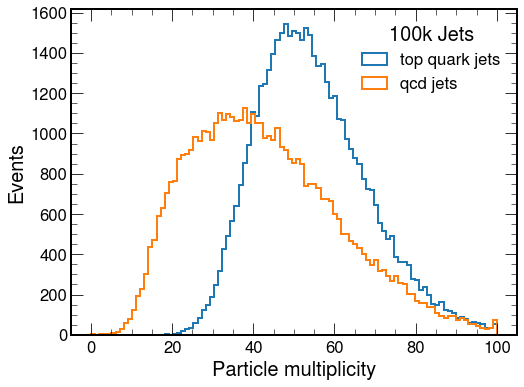

In [21]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(multiplicity["top"], bins=np.linspace(0,100,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(multiplicity["qcd"], bins=np.linspace(0,100,100), histtype="step", linewidth=2, label=f"qcd jets")

# ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.legend(title="100k Jets")
ax.set_xlabel(r"Particle multiplicity");
ax.set_ylabel(r"Events");

# Input features

In [36]:
# check input features
features = {}

feature eta corresponding to index 0


0it [00:00, ?it/s]

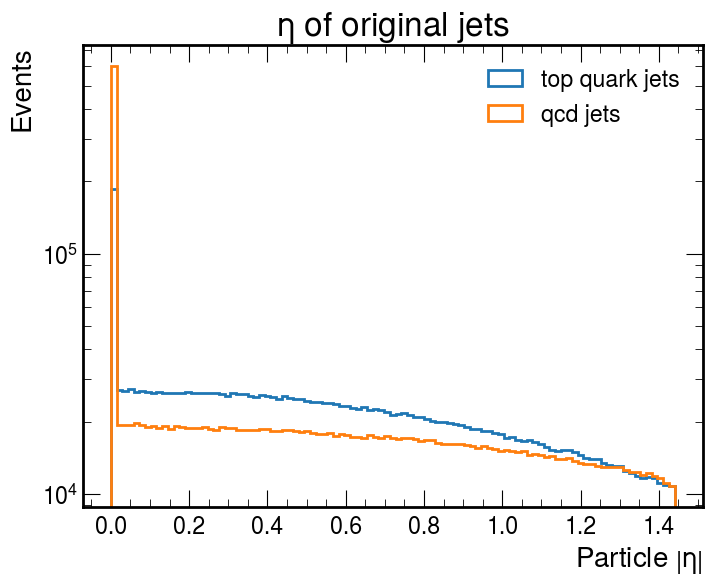

In [37]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
ax.set_yscale('log')
plt.title("$\eta$ of original jets")
plt.savefig(f"{save_path}/eta_orig", bbox_inches='tight', dpi=300)
plt.show()                   

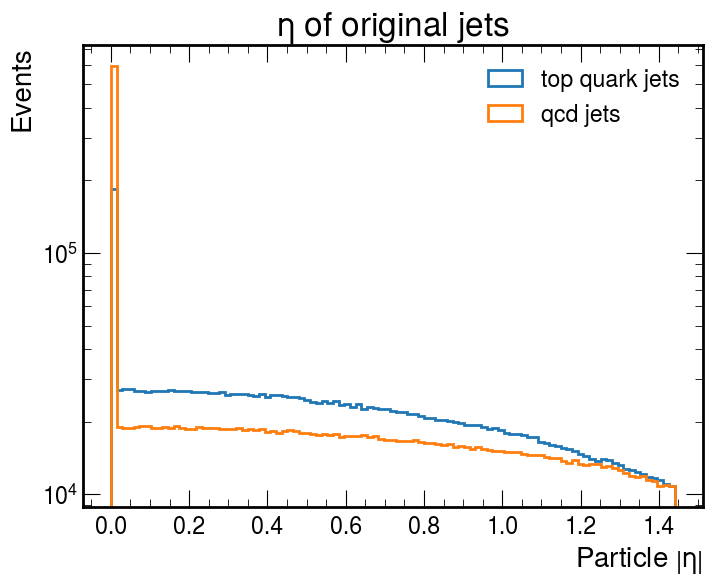

In [34]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
ax.set_yscale('log')
plt.title("$\eta$ of original jets")
plt.savefig(f"{save_path}/eta_orig", bbox_inches='tight', dpi=300)
plt.show()     

## Augmented Jets

feature eta corresponding to index 0


0it [00:00, ?it/s]

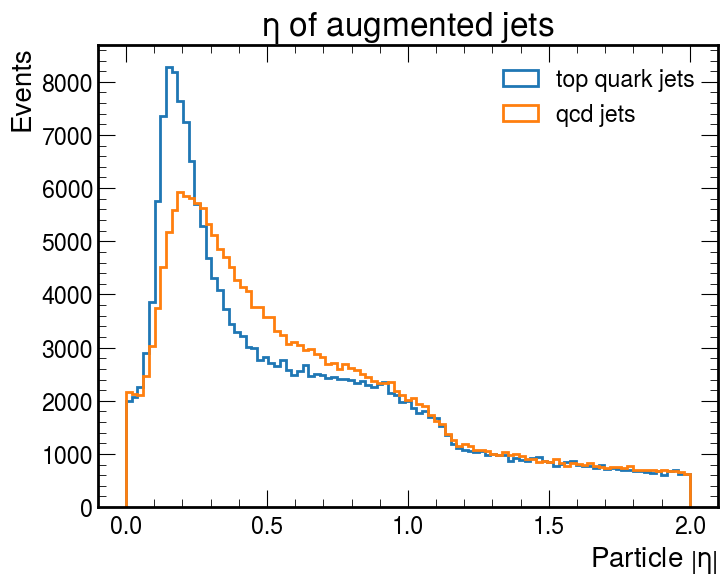

In [38]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of augmented jets")
plt.savefig(f"{save_path}/eta_augmented", bbox_inches='tight', dpi=300)
plt.show()          

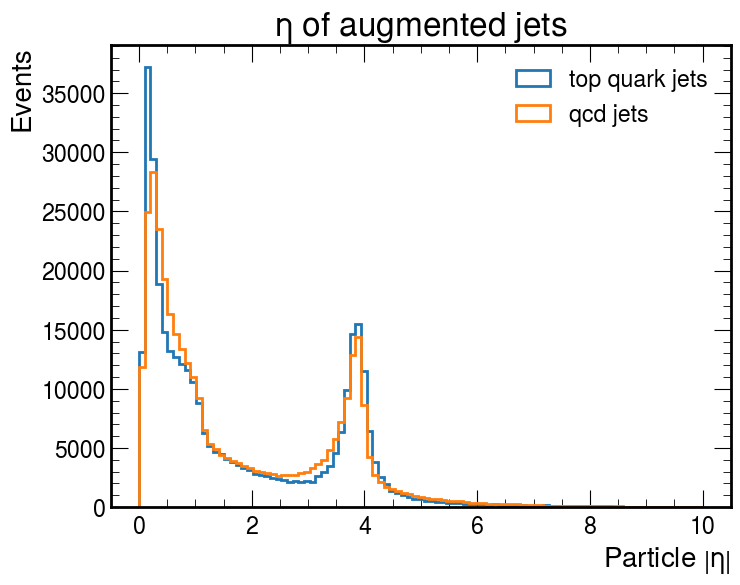

In [39]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of augmented jets")
plt.savefig(f"{save_path}/eta_augmented_extended", bbox_inches='tight', dpi=300)
plt.show()   

feature phi corresponding to index 1


0it [00:00, ?it/s]

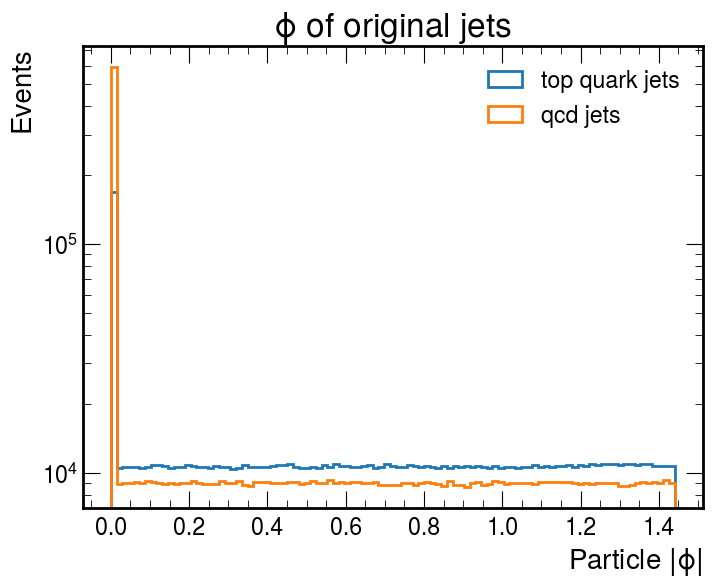

In [40]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,1.44,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
ax.set_yscale('log')
plt.title("$\phi$ of original jets")
plt.savefig(f"{save_path}/phi_orig", bbox_inches='tight', dpi=300)
plt.show()                   

feature phi corresponding to index 1


0it [00:00, ?it/s]

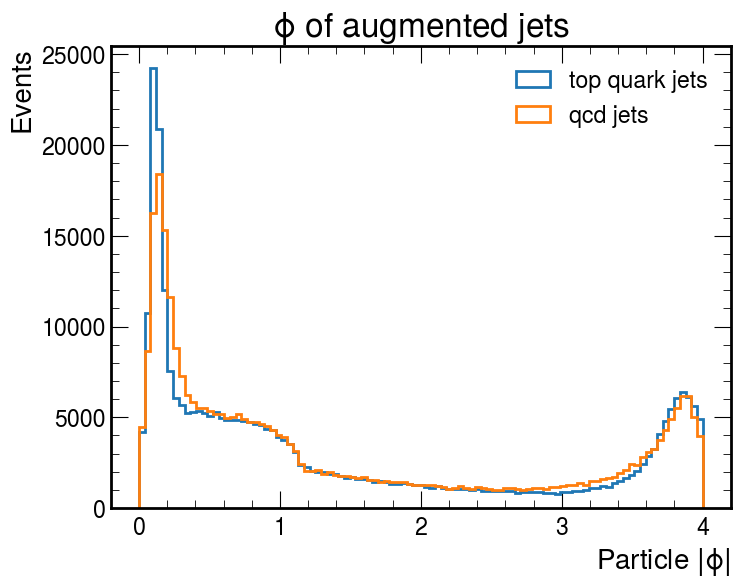

In [41]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of augmented jets")
plt.savefig(f"{save_path}/phi_augmented", bbox_inches='tight', dpi=300)
plt.show()                   

In [46]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            

feature pt corresponding to index 2


0it [00:00, ?it/s]

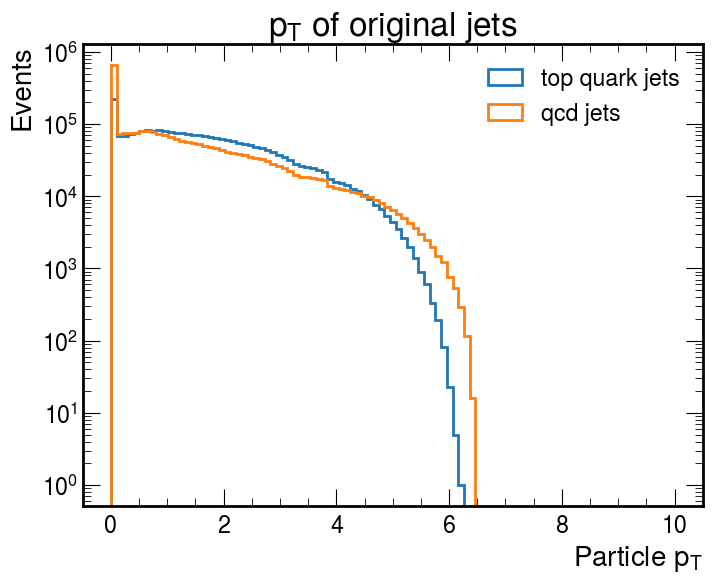

In [47]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
ax.set_yscale('log')
plt.title("$p_T$ of original jets")
plt.savefig(f"{save_path}/pT_orig", bbox_inches='tight', dpi=300)
plt.show()                   

feature pt corresponding to index 2


0it [00:00, ?it/s]

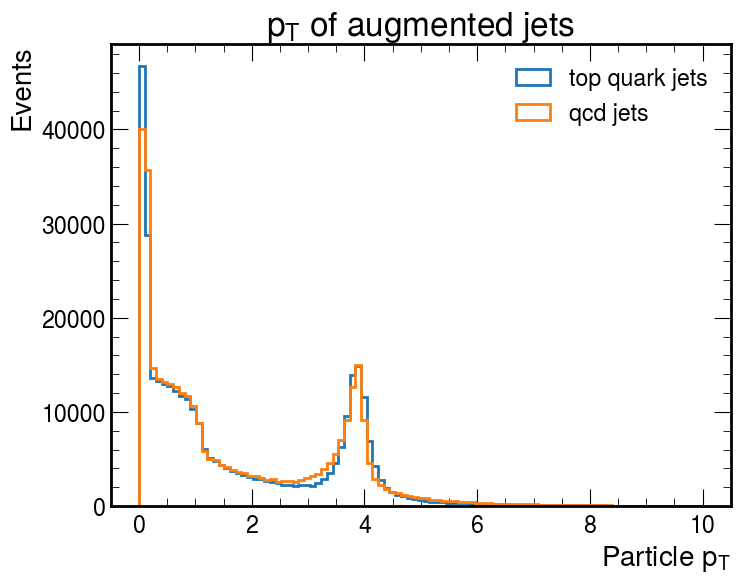

In [48]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of augmented jets")
plt.savefig(f"{save_path}/pT_augmented", bbox_inches='tight', dpi=300)
plt.show()                   

feature pt/jet_pt corresponding to index 4


0it [00:00, ?it/s]

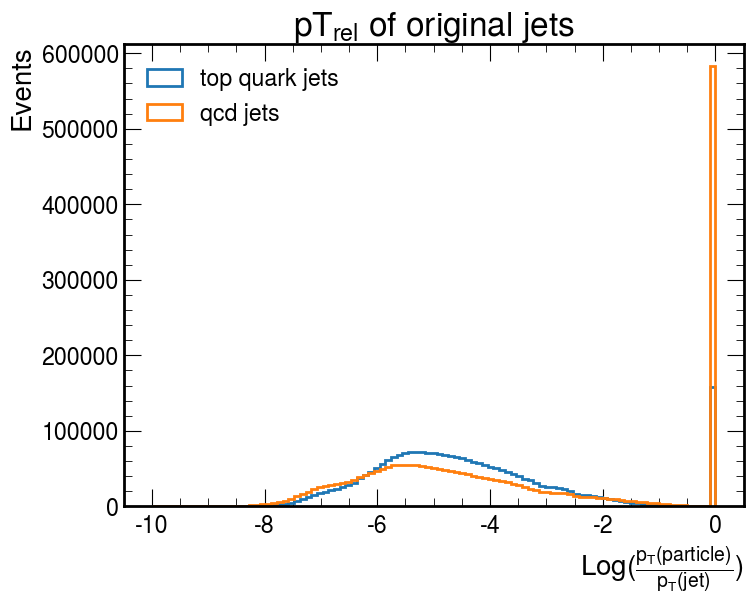

In [54]:
# which feature to look at?
feature = "pt/jet_pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$pT_{rel}$ of original jets")
plt.savefig(f"{save_path}/pTrel_orig", bbox_inches='tight', dpi=300)
plt.show()            

feature pt/jet_pt corresponding to index 4


0it [00:00, ?it/s]

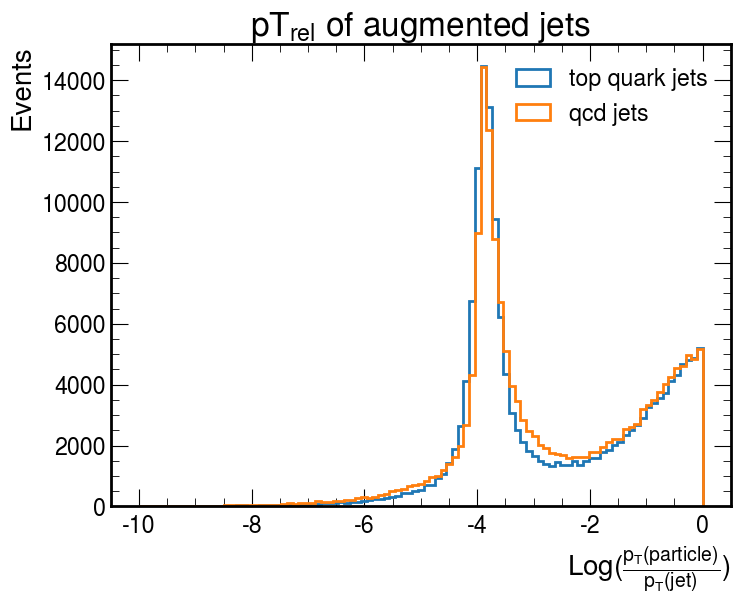

In [55]:
# which feature to look at?
feature = "pt/jet_pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$pT_{rel}$ of augmented jets")
plt.savefig(f"{save_path}/pTrel_augmented", bbox_inches='tight', dpi=300)
plt.show()            

feature pt/jet_pt corresponding to index 4


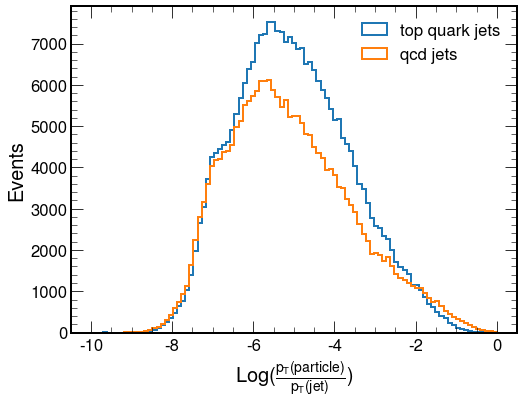

In [18]:
# which feature to look at?
feature = "pt/jet_pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

feature E/jet_E corresponding to index 5


0it [00:00, ?it/s]

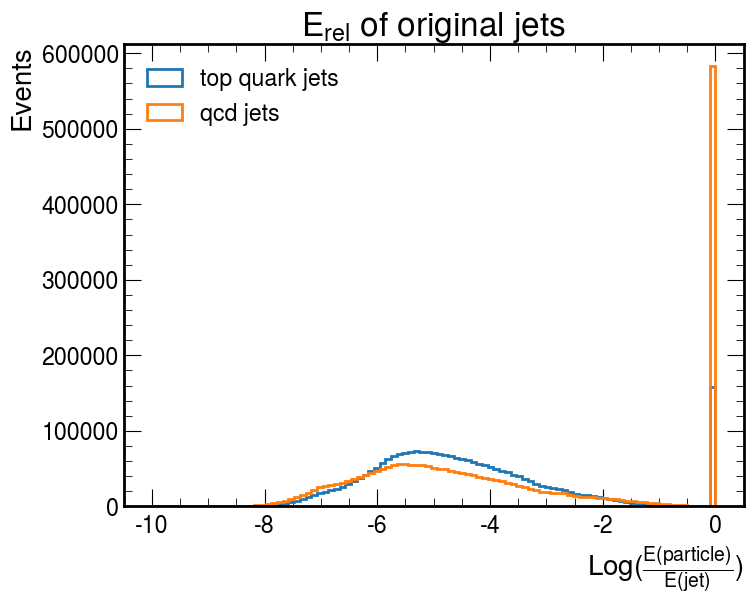

In [56]:
# which feature to look at?
feature = "E/jet_E"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$E_{rel}$ of original jets")
plt.savefig(f"{save_path}/Erel_orig", bbox_inches='tight', dpi=300)
plt.show()            

feature E/jet_E corresponding to index 5


0it [00:00, ?it/s]

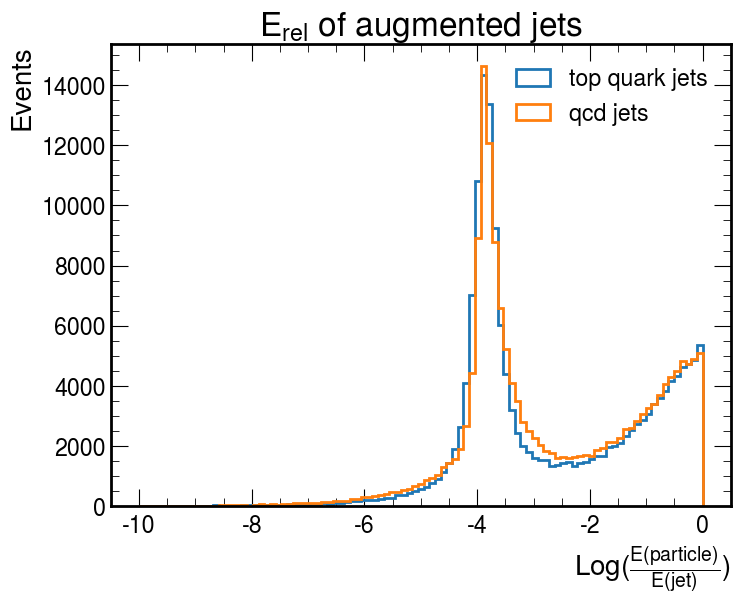

In [57]:
# which feature to look at?
feature = "E/jet_E"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$E_{rel}$ of augmented jets")
plt.savefig(f"{save_path}/Erel_augmented", bbox_inches='tight', dpi=300)
plt.show()            

feature E/jet_E corresponding to index 5


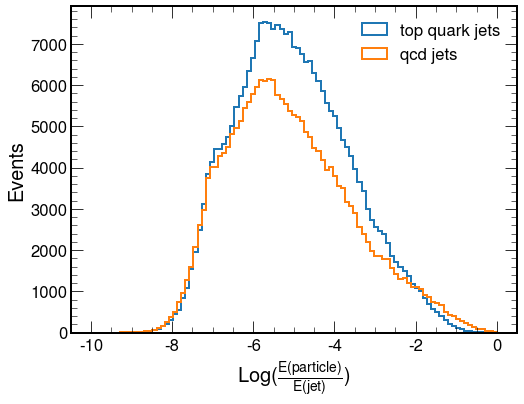

In [19]:
# which feature to look at?
feature = "E/jet_E"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet in tqdm(data[:10000]):
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.x:
        features[label].append(particle[index])
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(-10,0,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events");            

In [ ]:
# which feature to look at?
feature = "deltaR"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(all_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

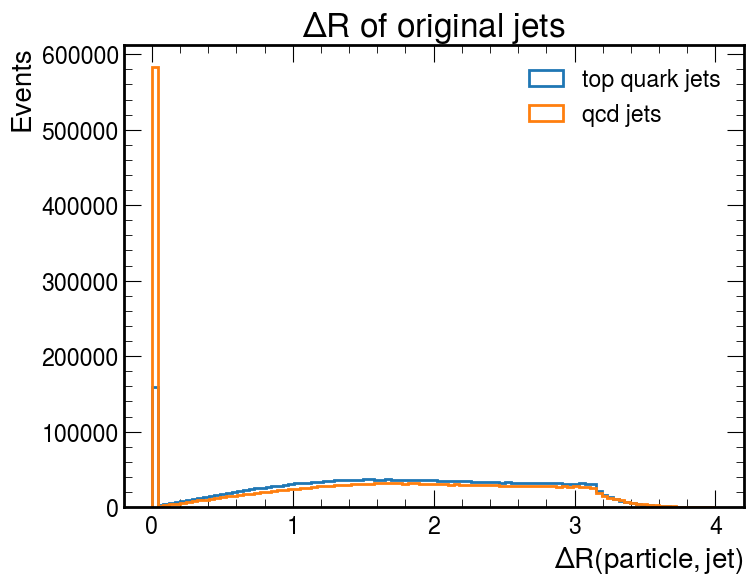

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\Delta R$ of original jets")
plt.savefig(f"{save_path}/deltaR_orig", bbox_inches='tight', dpi=300)
plt.show()            

feature deltaR corresponding to index 6


0it [00:00, ?it/s]

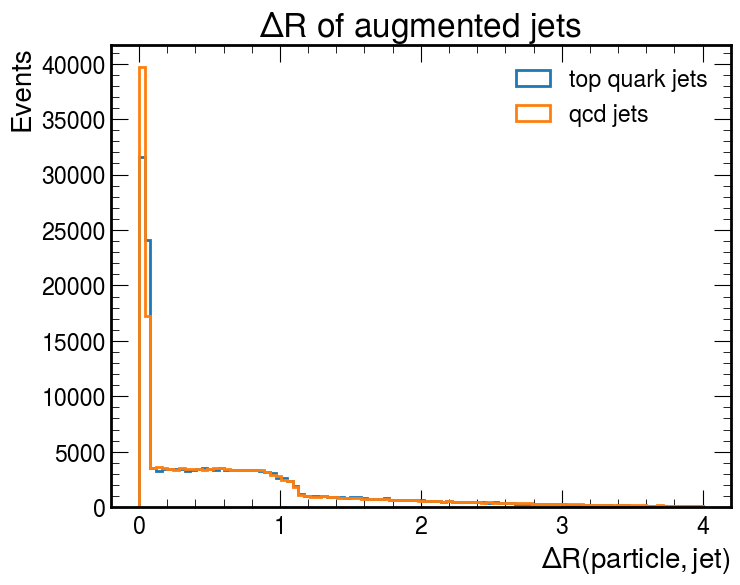

In [65]:
# which feature to look at?
feature = "deltaR"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(augmented_jets, all_labels)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(particle[index])
           
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\Delta R$ of augmented jets")
plt.savefig(f"{save_path}/deltaR_augmented", bbox_inches='tight', dpi=300)
plt.show()            

## Try to observe jet substructure

In [23]:
# look for the distribution of dR/distances between particles in jets
dists = {}
dists["top"] = []
dists["qcd"] = []

for jet in tqdm(data[:10000]):
    # dummy list of distances per jet that we will average over to get a single measure in the end
    l = []
    
    if jet.y==1:
        label = "top"
    else:
        label = "qcd"
        
    for ind_p in range(len(jet.x)):  # i_p stands for index of particle
        eta1 = jet.x[ind_p][feature_dict["eta"]]
        phi1 = jet.x[ind_p][feature_dict["phi"]]

        if ind_p < (len(jet.x)-1):
            for ind_n in range(ind_p+1, len(jet.x)):   # i_n stands for index of neighbor
                eta2 = jet.x[ind_n][feature_dict["eta"]]
                phi2 = jet.x[ind_n][feature_dict["phi"]]     
                
                deltaR = np.sqrt((eta1 - eta2)**2 + (phi1 - phi2)**2)
                
                l.append(np.round(deltaR.item(), decimals=4))
    
    dists[label].append(sum(l)/len(l))         

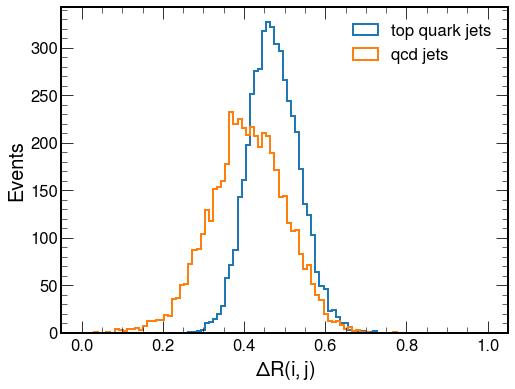

In [24]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(dists["top"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(dists["qcd"], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(r"$\Delta R(i,j)$");
ax.set_ylabel(r"Events");   

# Plotting jets

In [70]:
def plot_jet(jet_index):
    plt.style.use(hep.style.CMS)
    plt.rcParams.update({'font.size': 20})

    jet_input = data[jet_index].x
    jet_label = data[jet_index].y
    if jet_label==1:
        print(f"Jet # {jet_index} is a top quark jet")
    else:
        print(f"Jet # {jet_index} is a qcd jet")

    print('Building the graph...')        
    pt = jet_input[:, feature_dict["pt"]].unsqueeze(1)
    eta = jet_input[:, feature_dict["eta"]].unsqueeze(1)
    phi = jet_input[:, feature_dict["phi"]].unsqueeze(1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # get positions of nodes in the graph
    pos = {}
    num_nodes = len(jet_input)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    ax.scatter(
        eta,
        phi,
        c=pt,
        cmap='Greys',
        norm=colors.LogNorm(vmin=0.001, vmax=0.1),
    )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
#     cbar.set_label(r"$\frac{p_T(particle)}{p_T(jet)}$")
    cbar.set_label(r"$\frac{p_T}{p_T(jet)}$")

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6]) 
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
    ax.legend(title="Top quark jet" if jet_label==1 else "QCD jet", title_fontsize=25)
    # plt.savefig(f"/xai4hepvol/LRP/paper_plots/no_subjets_jet.pdf")    
    plt.show() 

No handles with labels found to put in legend.


Jet # 1 is a qcd jet
Building the graph...
Plotting the point cloud...


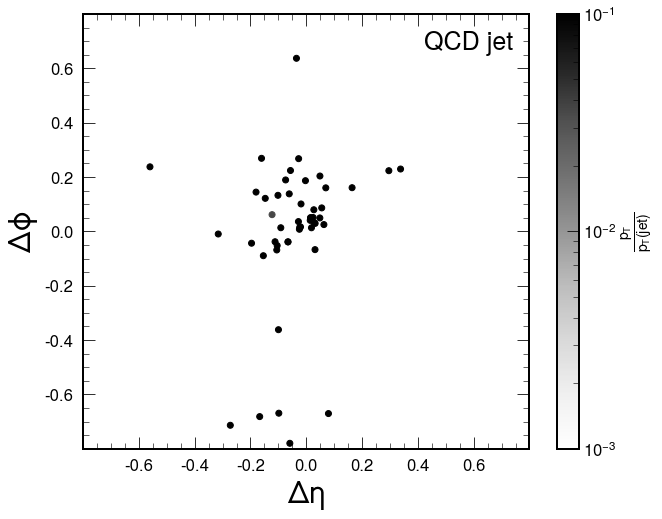

In [71]:
plot_jet(jet_index=1)

# Declustering jets

In [29]:
import awkward as ak
import fastjet
import vector
vector.register_awkward()
    
def get_subjets(px, py, pz, e, N_SUBJETS=3, JET_ALGO="CA", jet_radius=0.8):
    """
    Declusters a jet into exactly N_SUBJETS using the JET_ALGO and jet_radius provided.

    Args:
        px (np.ndarray): NumPy array of shape ``[num_particles]`` containing the px of each particle inside the jet.
        py (np.ndarray): NumPy array of shape ``[num_particles]`` containing the py of each particle inside the jet.
        pz (np.ndarray): NumPy array of shape ``[num_particles]`` containing the pz of each particle inside the jet.
        e (np.ndarray): NumPy array of shape ``[num_particles]`` containing the e of each particle inside the jet.
        N_SUBJETS (int): Number of subjets to decluster the jet into.
            (default is 3)
        JET_ALGO (str): The jet declustering algorithm to use. Choices are ["CA", "kt", "antikt"].
            (default is "CA")
        jet_radius (float): The jet radius to use when declustering.
            (default is 0.8)

    Returns:
        subjet_idx (np.array): NumPy array of shape ``[num_particles]`` with elements
                                representing which subjet the particle belongs to.
        subjet_vectors (list): includes bjet information (e.g. px, py, pz)

    """

    if JET_ALGO == "kt":
        JET_ALGO = fastjet.kt_algorithm
    elif JET_ALGO == "antikt":
        JET_ALGO = fastjet.antikt_algorithm
    elif JET_ALGO == "CA":
        JET_ALGO = fastjet.cambridge_algorithm

    jetdef = fastjet.JetDefinition(JET_ALGO, jet_radius)

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px, 
            "py": py,
            "pz": pz,
            "E": e,
        },
        with_name="Momentum4D",
    )

    pseudojet = [
        fastjet.PseudoJet(particle.px.item(), particle.py.item(), particle.pz.item(), particle.E.item()) for particle in jet
    ]

    cluster = fastjet.ClusterSequence(pseudojet, jetdef)

    # cluster jets
    jets = cluster.inclusive_jets()
    assert len(jets) == 1

    # get the 3 exclusive jets
    subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
    assert len(subjets) == N_SUBJETS

    # sort by pt
    subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

    # define a subjet_idx placeholder
    subjet_idx = ak.zeros_like(px, dtype=int) - 1
    mapping = subjet_idx.to_list()

    subjet_indices = []
    for subjet_idx, subjet in enumerate(subjets):
        subjet_indices.append([])
        for subjet_const in subjet.constituents():
            for idx, jet_const in enumerate(pseudojet):
                if (
                    subjet_const.px() == jet_const.px()
                    and subjet_const.py() == jet_const.py()
                    and subjet_const.pz() == jet_const.pz()
                    and subjet_const.E() == jet_const.E()
                ):
                    subjet_indices[-1].append(idx)

    for subjet_idx, subjet in enumerate(subjets):
        local_mapping = np.array(mapping)
        local_mapping[subjet_indices[subjet_idx]] = subjet_idx
        mapping = local_mapping

    # add the jet index
    jet["subjet_idx"] = ak.Array(mapping)

    subjet_vectors = [
        vector.obj(
            px=ak.sum(jet.px[jet.subjet_idx == j], axis=-1),
            py=ak.sum(jet.py[jet.subjet_idx == j], axis=-1),
            pz=ak.sum(jet.pz[jet.subjet_idx == j], axis=-1),
            E=ak.sum(jet.E[jet.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    return jet["subjet_idx"].to_numpy(), subjet_vectors

In [30]:
### some config
N_SUBJETS = 2
jet_radius = 0.8

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

# JET_ALGO = fastjet.kt_algorithm
# JET_ALGO = fastjet.antikt_algorithm
JET_ALGO = fastjet.cambridge_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, jet_radius) 

In [48]:
# check one jet at a time hence batch_size=1
batch_size = 1
loader = DataLoader(data, batch_size)

subjet_idxs = {}
for jet_type in ["top", "qcd"]:
    subjet_idxs[jet_type] = {}
    for sj in range(N_SUBJETS):
        subjet_idxs[jet_type][sj] = []

for ijet, jet in enumerate(loader):
    jet_label = jet.y

    if jet_label==1:
        jet_type = "top"
    else:
        jet_type = "qcd" 
        
    if len(subjet_idxs[jet_type][0]) == 1000:
        continue

    print(f"Jet # {ijet} is a {jet_type} jet")
    
    px = jet.px.detach().numpy()
    py = jet.py.detach().numpy()
    pz = jet.pz.detach().numpy()
    e = jet.E.detach().numpy()

    try:
        subjet_idx, subjet_vectors = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO)
    except:
        print(f"JET # {ijet} CANNOT BE DE-CLUSTERED PROPERLY")
    for sj in range(N_SUBJETS):
        subjet_idxs[jet_type][sj].append((subjet_idx==sj).sum())    
        
    if ijet==10:
        break

Jet # 0 is a qcd jet
Jet # 1 is a qcd jet
Jet # 2 is a qcd jet
Jet # 3 is a qcd jet
Jet # 4 is a qcd jet
Jet # 5 is a qcd jet
Jet # 6 is a qcd jet
Jet # 7 is a qcd jet
Jet # 8 is a qcd jet
Jet # 9 is a qcd jet
Jet # 10 is a qcd jet


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


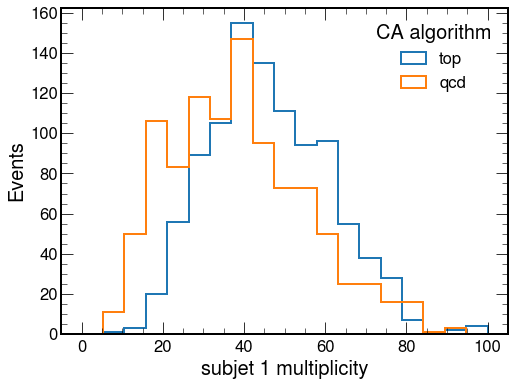

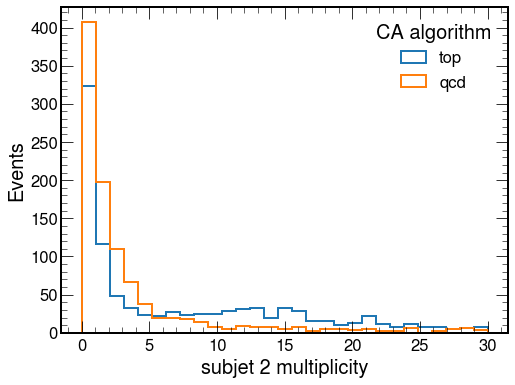

In [34]:
plt.rcParams.update({"font.size": 20})

### plot subjet1 multiplicity
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(subjet_idxs["top"][0], bins=np.linspace(0,100,20), histtype="step", linewidth=2, label=f"top")
plt.hist(subjet_idxs["qcd"][0], bins=np.linspace(0,100,20), histtype="step", linewidth=2, label=f"qcd")

ax.legend(title=f"{LABEL[JET_ALGO]} algorithm")
ax.set_xlabel(r"subjet 1 multiplicity");
ax.set_ylabel(r"Events");

### plot subjet2 multiplicity
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(subjet_idxs["top"][1], bins=np.linspace(0,30,30), histtype="step", linewidth=2, label=f"top")
plt.hist(subjet_idxs["qcd"][1], bins=np.linspace(0,30,30), histtype="step", linewidth=2, label=f"qcd")

ax.legend(title=f"{LABEL[JET_ALGO]} algorithm")
ax.set_xlabel(r"subjet 2 multiplicity");
ax.set_ylabel(r"Events");

## Plotting subjets

Jet # 0 is a qcd jet
Building the graph...
Plotting the point cloud...


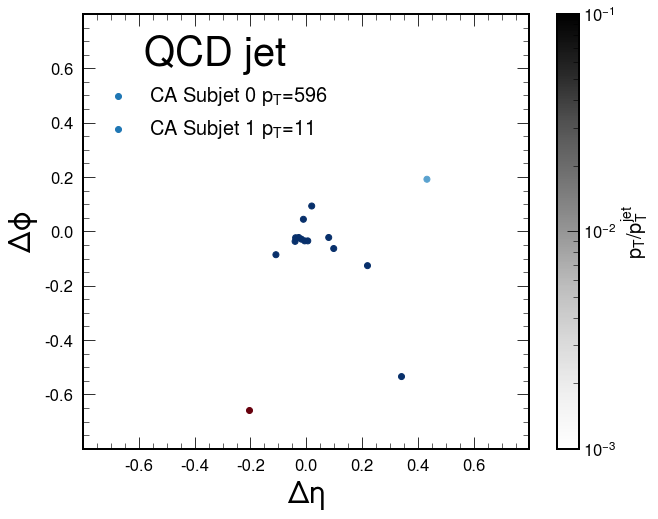

In [74]:
plt.rcParams.update({'font.size': 20})

jet_index = 0

for ijet, jet in enumerate(loader):

    if ijet!=jet_index:
        continue
        
    jet_label = jet.y

    if jet_label==1:
        jet_type = "top"
    else:
        jet_type = "qcd" 
        
    if len(subjet_idxs[jet_type][0]) == 1000:
        continue

    print(f"Jet # {ijet} is a {jet_type} jet")
    
    px = jet.px.detach().numpy()
    py = jet.py.detach().numpy()
    pz = jet.pz.detach().numpy()
    e = jet.E.detach().numpy()

    subjet_idx, subjet_vectors = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO)
        
    ### use the eta,phi relative to jet axis when plotting
    print('Building the graph...')        
    pt = jet.x[:, feature_dict["pt"]].unsqueeze(1)
    eta = jet.x[:, feature_dict["eta"]].unsqueeze(1)
    phi = jet.x[:, feature_dict["phi"]].unsqueeze(1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(jet)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Oranges', 'Yellows', 'Purples']

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets] 

    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    for j in range(Num_subjets):
        ax.scatter(
            eta[subjet_idx == j],
            phi[subjet_idx == j],
            c=pt[subjet_idx == j],
            cmap=COLOR_from_idx[j],
            norm=colors.LogNorm(vmin=0.001, vmax=0.01),
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")

    plt.legend(title="Top jet" if jet_label==1 else "QCD jet", title_fontsize=40, fontsize=20)  

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])    
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
    # plt.legend(fontsize=23)
    # plt.savefig(f"/xai4hepvol/LRP/paper_plots/jet.pdf")    
    plt.show() 

    if ijet==jet_index:
        break